In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [96]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


 82%|████████▏ | 53598/65034 [02:33<00:18, 627.03it/s]

In [ ]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 496
Num labels EPOC: 11
Labels EPOC: ['0', '1', '2', '6', '3', '5', '8', '4', '7', '-1', '9']
------------------------------------
Data shape EPOC (256, 14)


In [ ]:
for point in tqdm(all_points):
    #point.full_clean(channels=['T7', 'P7', 'P8', 'T8'])
    point.crop_to_channels(channels=['T7', 'P7', 'P8', 'T8'])

  0%|          | 0/496 [00:00<?, ?it/s]

In [ ]:
# all_points[15].mne_object.plot(scalings = 'auto');

for i in range(50):
    print(np.max(all_points[i].raw_data), np.min(all_points[i].raw_data))

4522.564102 4180.51282
4532.820512 4212.820512
4500.0 4140.51282
4418.461538 3952.307693
4525.641025 4199.487179
4526.153846 4151.282051
4550.76923 4184.615384
4516.410256 4174.871794
4646.666666 3702.051283
4500.0 4152.307692
4518.974358 4181.538461
4503.589743 4194.871794
4543.076923 4182.564102
4486.153846 4166.153846
4511.794871 4161.025641
4513.333333 4182.051282
4648.717948 4182.564102
4469.230769 4109.743589
4575.897435 4184.102564
4521.538461 4136.410256
4513.333333 4175.384615
4481.538461 4141.025641
4555.384615 4180.51282
4537.435897 4075.897435
4538.461538 4192.307692
4534.871794 4164.102564
4517.435897 4186.153846
4548.717948 4134.358974
4575.384615 4191.794871
4523.589743 4178.461538
4521.538461 4182.564102
4533.333333 4151.282051
4531.794871 4178.461538
4531.794871 4158.461538
4536.923076 4180.51282
4531.794871 4183.589743
4538.461538 4182.564102
4506.666666 4115.897435
4596.410256 4154.358974
4543.589743 4078.974358
4524.102564 4183.076923
4530.76923 4165.128205
4586.153

In [62]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from models.EegClassifierA import Classifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
https://github.com/vlawhern/arl-eegmodels

https://github.com/SuperBruceJia/EEG-DL

https://github.com/SuperBruceJia/EEG-Motor-Imagery-Classification-CNNs-TensorFlow

In [66]:
batch_size = 32
num_workers = 4

dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True)

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers)

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = Classifier().to(device=device)

optimizer = Adam(model.parameters(), lr=0.001)                                           
loss_function = nn.CrossEntropyLoss()

n_epochs = 100

validation_data = []
training_data = []

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()

    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)

        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().data*data.size(0)

        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==expected_prediction))        
        
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)

    print("------------------Validating--------------------")
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        #Prediction
        expected_prediction = []
        for i in labels:
            expected_prediction.append(((i == 1).nonzero(as_tuple=True)[0]))
        expected_prediction = torch.Tensor(expected_prediction).type(torch.int16).to(device)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy+=int(torch.sum(prediction==expected_prediction))        
        #Loss
        val_loss += loss_function(outputs, labels)*data.size(0)

    val_loss /= len(test_dataloader)
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)

cuda
Epoch 1/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.624870777130127
Epoch accuracy: 0.09976407797029703
------------------Validating--------------------
Validation loss: 2.6232945919036865
Validation accuracy: 0.09645730198019802
Epoch 2/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.620471239089966
Epoch accuracy: 0.10475324876237624
------------------Validating--------------------
Validation loss: 2.621497631072998
Validation accuracy: 0.10032487623762376
Epoch 3/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.618872880935669
Epoch accuracy: 0.10676438737623763
------------------Validating--------------------
Validation loss: 2.6213314533233643
Validation accuracy: 0.1015625
Epoch 4/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.6167807579040527
Epoch accuracy: 0.11302985767326733
------------------Validating--------------------
Validation loss: 2.6214699745178223
Validation accuracy: 0.09661200495049505
Epoch 5/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.6154091358184814
Epoch accuracy: 0.11388072400990099
------------------Validating--------------------
Validation loss: 2.6217236518859863
Validation accuracy: 0.10303217821782178
Epoch 6/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.612605333328247
Epoch accuracy: 0.11970142326732673
------------------Validating--------------------
Validation loss: 2.6243436336517334
Validation accuracy: 0.10125309405940594
Epoch 7/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.6081900596618652
Epoch accuracy: 0.1276879641089109
------------------Validating--------------------
Validation loss: 2.628465414047241
Validation accuracy: 0.09769492574257425
Epoch 8/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.6052305698394775
Epoch accuracy: 0.13499767945544555
------------------Validating--------------------
Validation loss: 2.6270878314971924
Validation accuracy: 0.10241336633663366
Epoch 9/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5999114513397217
Epoch accuracy: 0.14097308168316833
------------------Validating--------------------
Validation loss: 2.6313986778259277
Validation accuracy: 0.10380569306930693
Epoch 10/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5937342643737793
Epoch accuracy: 0.1475479579207921
------------------Validating--------------------
Validation loss: 2.6341655254364014
Validation accuracy: 0.10133044554455446
Epoch 11/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.586787700653076
Epoch accuracy: 0.15895730198019803
------------------Validating--------------------
Validation loss: 2.637917995452881
Validation accuracy: 0.10272277227722772
Epoch 12/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5806949138641357
Epoch accuracy: 0.1647199876237624
------------------Validating--------------------
Validation loss: 2.642123222351074
Validation accuracy: 0.10202660891089109
Epoch 13/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5743465423583984
Epoch accuracy: 0.17338335396039603
------------------Validating--------------------
Validation loss: 2.64540433883667
Validation accuracy: 0.10558477722772278
Epoch 14/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.564117431640625
Epoch accuracy: 0.17962948638613863
------------------Validating--------------------
Validation loss: 2.6561965942382812
Validation accuracy: 0.10434715346534654
Epoch 15/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5551705360412598
Epoch accuracy: 0.1895304764851485
------------------Validating--------------------
Validation loss: 2.6629180908203125
Validation accuracy: 0.10403774752475248
Epoch 16/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.546912670135498
Epoch accuracy: 0.1995474938118812
------------------Validating--------------------
Validation loss: 2.6733856201171875
Validation accuracy: 0.10233601485148515
Epoch 17/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5360448360443115
Epoch accuracy: 0.20672184405940594
------------------Validating--------------------
Validation loss: 2.6827163696289062
Validation accuracy: 0.10326423267326733
Epoch 18/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5253400802612305
Epoch accuracy: 0.216796875
------------------Validating--------------------
Validation loss: 2.6976003646850586
Validation accuracy: 0.10225866336633663
Epoch 19/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.5093469619750977
Epoch accuracy: 0.2279741646039604
------------------Validating--------------------
Validation loss: 2.695223093032837
Validation accuracy: 0.10241336633663366
Epoch 20/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.499619245529175
Epoch accuracy: 0.2347810952970297
------------------Validating--------------------
Validation loss: 2.7055108547210693
Validation accuracy: 0.10566212871287128
Epoch 21/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.4816818237304688
Epoch accuracy: 0.24648050742574257
------------------Validating--------------------
Validation loss: 2.73020339012146
Validation accuracy: 0.10303217821782178
Epoch 22/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.4668045043945312
Epoch accuracy: 0.2559173886138614
------------------Validating--------------------
Validation loss: 2.7390081882476807
Validation accuracy: 0.10078898514851485
Epoch 23/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.4553518295288086
Epoch accuracy: 0.2634011448019802
------------------Validating--------------------
Validation loss: 2.7611844539642334
Validation accuracy: 0.10457920792079207
Epoch 24/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.432293176651001
Epoch accuracy: 0.2766862623762376
------------------Validating--------------------
Validation loss: 2.765361785888672
Validation accuracy: 0.10527537128712872
Epoch 25/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7ff371047250>
Traceback (most recent call last):
  File "/home/student/andrew/anaconda3/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch train loss: 2.416851758956909
Epoch accuracy: 0.2856783725247525
------------------Validating--------------------
Validation loss: 2.7850804328918457
Validation accuracy: 0.10140779702970297
Epoch 26/100


  0%|          | 0/1616 [00:00<?, ?it/s]

KeyboardInterrupt: 

[2.6232945919036865, 2.621497631072998, 2.6213314533233643, 2.6214699745178223, 2.6217236518859863, 2.6243436336517334, 2.628465414047241, 2.6270878314971924, 2.6313986778259277, 2.6341655254364014, 2.637917995452881, 2.642123222351074, 2.64540433883667, 2.6561965942382812, 2.6629180908203125, 2.6733856201171875, 2.6827163696289062, 2.6976003646850586, 2.695223093032837, 2.7055108547210693, 2.73020339012146, 2.7390081882476807, 2.7611844539642334, 2.765361785888672, 2.7850804328918457]


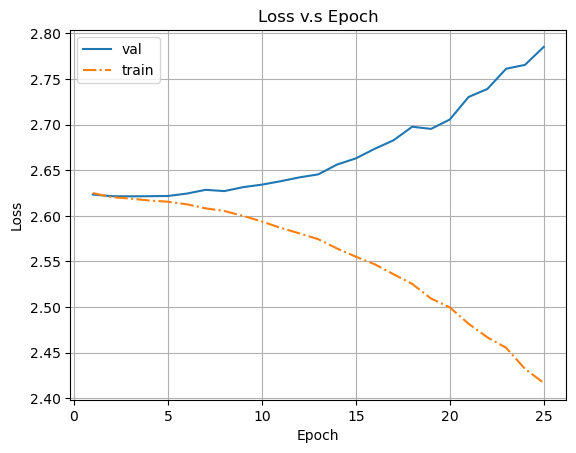

In [84]:
print(validation_data)
x = [i+1 for i in range(len(validation_data))]

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Loss v.s Epoch')
plt.grid()

plt.show()